In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf1
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
print(tf.config.experimental.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
text_data = np.load("Text-numpy.npy")
img_data = np.load("Images-numpy.npy")

In [21]:
text_data.shape,img_data.shape

((535, 5), (535, 100, 400, 3))

In [22]:
## in the data preparation phase i got to perform normalization so let's do it here
img_data = img_data/255

In [23]:
## split data into train data and test data
trainImages,testImages,trainText,testText = train_test_split(img_data,text_data,test_size=0.3)

In [24]:
trainTarget = trainText[:,4]
testTarget = testText[:,4]

In [31]:
trainText  = trainText[:,:4]
testText  = testText[:,:4]

In [14]:
def build_model(activation="relu",batch_norm=False):

    cnn_model = tf.keras.models.Sequential()


    cnn_model.add(Input(shape=(100,400,3)))

    cnn_model.add(Conv2D(filters=32,activation=activation,kernel_size=(3,3)))
    cnn_model.add(MaxPooling2D((2,2)))
    if(batch_norm):
        cnn_model.add(BatchNormalization())
        
    cnn_model.add(Conv2D(filters=64,activation=activation,kernel_size=(3,3)))
    cnn_model.add(MaxPooling2D((2,2)))
    if(batch_norm):
        cnn_model.add(BatchNormalization())

    cnn_model.add(Conv2D(filters=64,activation=activation,kernel_size=(3,3)))
    cnn_model.add(MaxPooling2D((2,2)))
    if(batch_norm):
        cnn_model.add(BatchNormalization())

    cnn_model.add(GlobalMaxPooling2D())
    cnn_model.add(Dense(1024,activation=activation))
    cnn_model.add(Dense(256,activation=activation))


    mlp_nn = tf.keras.models.Sequential([

        Input(shape=(4,)),
        Dense(256,activation=activation),
        Dense(128,activation=activation),
        Dense(64,activation=activation),
    ])

    concat_input = concatenate([cnn_model.output , mlp_nn.output ])

    x = Dense(4,activation=activation)(concat_input)
    x = Dense(1,activation="sigmoid")(x)


    md = tf.keras.models.Model(inputs=[cnn_model.input , mlp_nn.input ] , outputs = x)
    md.compile(loss="mse", optimizer="adam",metrics=["mae",tf.keras.metrics.RootMeanSquaredError()])
    return md


### train model without batch normalization

In [15]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

md = build_model()
history_relu = md.fit(x=[trainImages , trainText] , y=trainTarget,epochs=50,validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/50
10/10 [==============================] - 72s 1s/step - loss: 0.0329 - mae: 0.1289 - root_mean_squared_error: 0.1814 - val_loss: 0.0124 - val_mae: 0.0892 - val_root_mean_squared_error: 0.1116
Epoch 2/50
10/10 [==============================] - 4s 365ms/step - loss: 0.0178 - mae: 0.0979 - root_mean_squared_error: 0.1334 - val_loss: 0.0120 - val_mae: 0.0875 - val_root_mean_squared_error: 0.1097
Epoch 3/50
10/10 [==============================] - 4s 366ms/step - loss: 0.0164 - mae: 0.0916 - root_mean_squared_error: 0.1280 - val_loss: 0.0118 - val_mae: 0.0814 - val_root_mean_squared_error: 0.1084
Epoch 4/50
10/10 [==============================] - 3s 294ms/step - loss: 0.0146 - mae: 0.0815 - root_mean_squared_error: 0.1209 - val_loss: 0.0079 - val_mae: 0.0652 - val_root_mean_squared_error: 0.0890
Epoch 5/50
10/10 [==============================] - 3s 322ms/step - loss: 0.0107 - mae: 0.0658 - root_mean_squared_error: 0.1032 - val_loss: 0.0048 - val_mae: 0.0521 - val_root_mean_squa

10/10 [==============================] - 4s 359ms/step - loss: 0.0026 - mae: 0.0333 - root_mean_squared_error: 0.0508 - val_loss: 0.0059 - val_mae: 0.0603 - val_root_mean_squared_error: 0.0766
Epoch 42/50
10/10 [==============================] - 3s 338ms/step - loss: 0.0023 - mae: 0.0318 - root_mean_squared_error: 0.0479 - val_loss: 0.0056 - val_mae: 0.0581 - val_root_mean_squared_error: 0.0749
Epoch 43/50
10/10 [==============================] - 4s 357ms/step - loss: 0.0021 - mae: 0.0284 - root_mean_squared_error: 0.0455 - val_loss: 0.0046 - val_mae: 0.0486 - val_root_mean_squared_error: 0.0675
Epoch 44/50
10/10 [==============================] - 4s 417ms/step - loss: 0.0019 - mae: 0.0271 - root_mean_squared_error: 0.0437 - val_loss: 0.0053 - val_mae: 0.0551 - val_root_mean_squared_error: 0.0730
Epoch 45/50
10/10 [==============================] - 4s 358ms/step - loss: 0.0017 - mae: 0.0246 - root_mean_squared_error: 0.0412 - val_loss: 0.0051 - val_mae: 0.0531 - val_root_mean_squared_e

In [16]:
md.evaluate([testImages,testText],testTarget)

6/6 [==============================] - 20s 4s/step - loss: 0.0069 - mae: 0.0532 - root_mean_squared_error: 0.0832


[0.006923190783709288, 0.05322949215769768, 0.0832057073712349]

<AxesSubplot:>

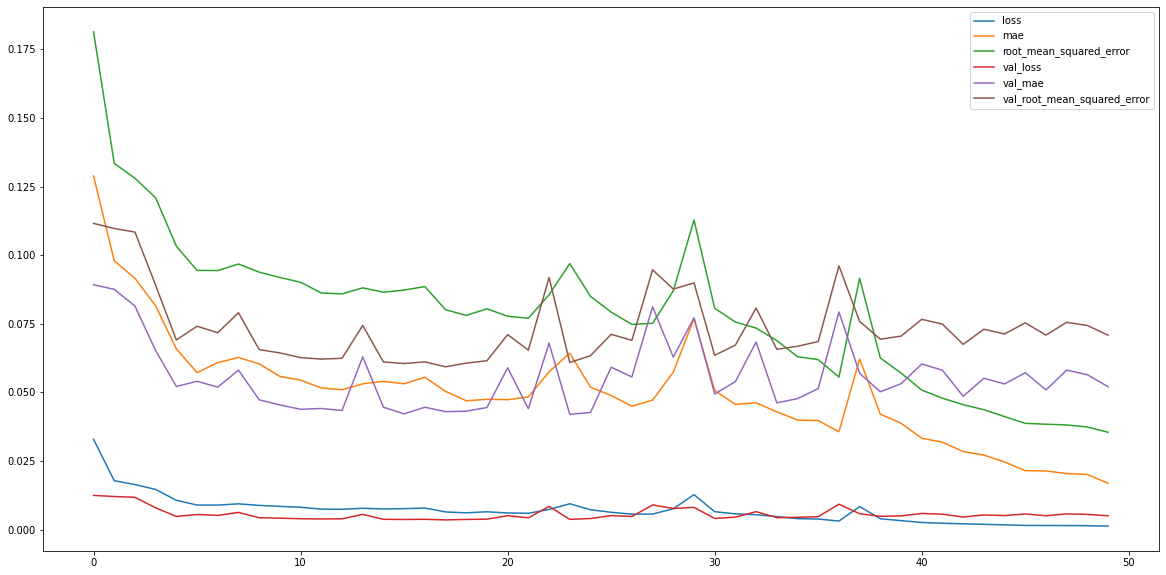

In [29]:

pd.DataFrame(data = history_relu.history).plot(figsize=(20,10))

### Train model with batch normalization

In [32]:
final_md = build_model(batch_norm=True)
history = final_md.fit(x=[trainImages , trainText] , y=trainTarget,epochs=50,validation_split=0.2,callbacks=[tensorboard_callback])

Epoch 1/50
10/10 [==============================] - 6s 486ms/step - loss: 0.0186 - mae: 0.1088 - root_mean_squared_error: 0.1362 - val_loss: 0.0080 - val_mae: 0.0691 - val_root_mean_squared_error: 0.0896
Epoch 2/50
10/10 [==============================] - 3s 313ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0088 - val_mae: 0.0728 - val_root_mean_squared_error: 0.0939
Epoch 3/50
10/10 [==============================] - 3s 344ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0094 - val_mae: 0.0744 - val_root_mean_squared_error: 0.0967
Epoch 4/50
10/10 [==============================] - 3s 319ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0096 - val_mae: 0.0753 - val_root_mean_squared_error: 0.0981
Epoch 5/50
10/10 [==============================] - 3s 316ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0097 - val_mae: 0.0756 - val_root_mean_sq

10/10 [==============================] - 4s 334ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0119 - val_mae: 0.0886 - val_root_mean_squared_error: 0.1090
Epoch 42/50
10/10 [==============================] - 3s 344ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0119 - val_mae: 0.0886 - val_root_mean_squared_error: 0.1090
Epoch 43/50
10/10 [==============================] - 4s 392ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0119 - val_mae: 0.0886 - val_root_mean_squared_error: 0.1090
Epoch 44/50
10/10 [==============================] - 3s 327ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0119 - val_mae: 0.0886 - val_root_mean_squared_error: 0.1090
Epoch 45/50
10/10 [==============================] - 3s 324ms/step - loss: 0.0181 - mae: 0.1044 - root_mean_squared_error: 0.1346 - val_loss: 0.0119 - val_mae: 0.0886 - val_root_mean_squared_e

#### here you can analyze that model is not learning anything when we use batch normalization , 

#### so we will use model without batch normalization.

In [33]:
final_md.evaluate([testImages,testText],testTarget)

6/6 [==============================] - 1s 105ms/step - loss: 0.0195 - mae: 0.0992 - root_mean_squared_error: 0.1397


[0.019508395344018936, 0.09919100999832153, 0.13967245817184448]

##### Best model performance

In [34]:
print("Training performance : ")
md.evaluate([trainImages,trainText],trainTarget)
print("Testing performance : ")
md.evaluate([testImages,testText],testTarget)

Training performance : 
12/12 [==============================] - 3s 256ms/step - loss: 0.0032 - mae: 0.0307 - root_mean_squared_error: 0.0568
Testing performance : 
6/6 [==============================] - 1s 94ms/step - loss: 0.0040 - mae: 0.0347 - root_mean_squared_error: 0.0630


[0.003964198287576437, 0.034666333347558975, 0.0629618763923645]